# Hackathon : Reinforcement Learning for Drone Navigation

- Team name: Les Floridiens
- Team members names:
    - Loïc GIRALDI
    - Carla BILLETER
    - Manuel NOVO-LOPES
    - Sophie GONZALEZ

## 0. Prerequisites

In [2]:
%pip -q install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch import optim

from agent import MyAgent
from behaviorcloning import clone_behavior
from models import DRQNetwork, MixingNetwork
import simulate
from transferlearning import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cloned_policy_path = "./cloned_policy"
pretrained_mixer_path = "./pretrained_mixer"
fine_tuned_policy_path = "./fine_tuned_policy"
fine_tuned_mixer_path = "./fine_tuned_mixer"

## 1.1 Behavior cloning

In [6]:
policy_net = DRQNetwork(
    state_size=42,
    action_size=7,
    hidden_size=512,
    num_recurrent_layers=2,
).to(device)

optimizer = optim.AdamW(
    policy_net.parameters(),
    lr=1e-4,
    weight_decay=1e-2
)

losses = clone_behavior(policy_net, optimizer, device, num_episodes=3000)

policy_net.save(cloned_policy_path)

episode=0, loss=1.949580430984497
episode=20, loss=1.6959577798843384
episode=40, loss=1.1145846843719482
episode=60, loss=1.082749605178833
episode=80, loss=1.1659493446350098
episode=100, loss=1.095371961593628
Interrupted


In [ ]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Episodes")
ax.set_ylabel("Training loss (cross-entropy)")

## 1.2 Transfer learning: Mixing layer optimization

In [19]:
cloned_policy_net = DRQNetwork.load(cloned_policy_path).to(device)
cloned_policy_net.gru.flatten_parameters()

num_agents = 4
central_state_size = 12 * num_agents + 901
mixer = MixingNetwork(
    num_agents=4,
    central_state_size=central_state_size,
    embedding_size=512,
    hypernet_size=1028,
).to(device)

agent = MyAgent(
    num_agents=4,
    device=device,
    policy_net=cloned_policy_net,
    mixing_net=mixer,
    buffer_size=2000,
    batch_sequence_length=20,
    batch_size=64,
    lr=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.9995,
    target_update_freq=1,
    tau=1e-3,
    gradient_clipping_value=10,
)

# Freeze the policy
for p in agent.policy_net.parameters():
    p.requires_grad = False

agent.optimizer = optim.AdamW(agent.mixer.parameters(), lr=agent.lr)

agent, all_rewards, all_losses = train(agent, num_episodes=200)

agent.mixer.save(pretrained_mixer_path)

Using QMIX agent with mixer network
DRQNetwork(
  (feature_layer): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=512, out_features=7, bias=True)
)
MixingNetwork(
  (hyper_w1): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=2048, bias=True)
  )
  (hyper_w2): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=512, bias=True)
  )
  (hyper_b1): Linear(in_features=949, out_features=512, bias=True)
  (hyper_b2): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=1, bias=True)
  )
)
Episode 1, Step 36, Reward: -

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Episode 65, Step 23, Reward: -27001.34, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 6.76e+02
Episode 66, Step 18, Reward: -9000.65, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 4.94e+02
Episode 67, Step 21, Reward: -20002.76, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 3.37e+02
Episode 68, Step 46, Reward: -77001.33, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 2.15e+02
Episode 69, Step 139, Reward: -220997.56, Evacuated: 1, Deactivated: 3, MEAN TD LOSS: 1.21e+02
Episode 70, Step 35, Reward: -6980.78, Evacuated: 2, Deactivated: 2, MEAN TD LOSS: 9.64e+01
Episode 71, Step 35, Reward: -58001.78, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 8.62e+01
Episode 72, Step 22, Reward: -32002.43, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 8.34e+01
Episode 73, Step 31, Reward: -43002.49, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 8.11e+01
Episode 74, Step 49, Reward: -110002.34, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 7.41e+01
Episode 75, Step 139, Reward: -138995.74, Evacuated: 1, Deactivated: 

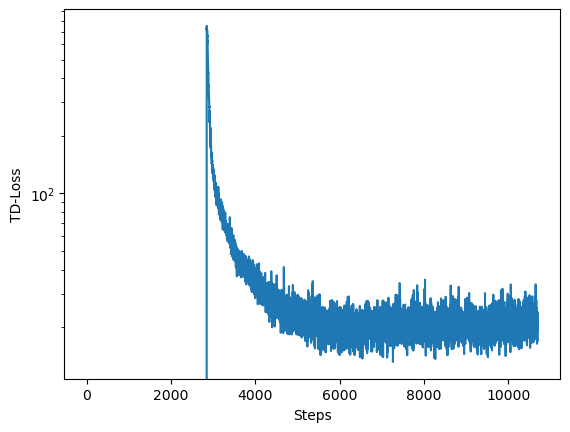

<Figure size 640x480 with 1 Axes>


In [23]:
fig, ax = plt.subplots()
ax.semilogy(all_losses)
ax.set_xlabel("Steps")
ax.set_ylabel("TD-Loss")
fig

## Fine Tuning

In [ ]:
cloned_policy_net = DRQNetwork.load(cloned_policy_path).to(device)
cloned_policy_net.train()
cloned_policy_net.gru.flatten_parameters()

pretrained_mixer = MixingNetwork.load(pretrained_mixer_path).to(device)
pretrained_mixer.train()

my_agent = MyAgent(
    num_agents=4,
    device=device,
    policy_net=cloned_policy_net,
    mixing_net=pretrained_mixer,
    buffer_size=2000,
    batch_sequence_length=20,
    batch_size=64,
    lr=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.9995,
    target_update_freq=1,
    tau=1e-3,
    gradient_clipping_value=1,
)

my_agent.optimizer = optim.AdamW(
    list(my_agent.policy_net.parameters()) + list(my_agent.mixer.parameters()),
    lr=1e-5,
    weight_decay=1e-5,
    eps=1e-5,
)

trained_agent, all_rewards, all_losses = train(my_agent, num_episodes=2000)

Using QMIX agent with mixer network
DRQNetwork(
  (feature_layer): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (gru): GRU(512, 512, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=512, out_features=7, bias=True)
)
MixingNetwork(
  (hyper_w1): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=2048, bias=True)
  )
  (hyper_w2): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=512, bias=True)
  )
  (hyper_b1): Linear(in_features=949, out_features=512, bias=True)
  (hyper_b2): Sequential(
    (0): Linear(in_features=949, out_features=1028, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1028, out_features=1, bias=True)
  )
)
Episode 1, Step 52, Reward: -

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:1139: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.gru(input, hx, self._flat_weights, self.bias, self.num_layers,


Episode 65, Step 60, Reward: -97005.80, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 4.56e+01
Episode 66, Step 155, Reward: -351008.77, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 2.22e+01
Episode 67, Step 72, Reward: -134006.06, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 1.62e+01
Episode 68, Step 500, Reward: -674069.26, Evacuated: 0, Deactivated: 3, MEAN TD LOSS: 1.19e+01
Episode 69, Step 98, Reward: -234007.60, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 9.20e+00
Episode 70, Step 331, Reward: -916011.25, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 8.34e+00
Episode 71, Step 118, Reward: -206003.66, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 7.80e+00
Episode 72, Step 67, Reward: -153002.16, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 7.59e+00
Episode 73, Step 306, Reward: -307011.97, Evacuated: 0, Deactivated: 4, MEAN TD LOSS: 6.90e+00
Episode 74, Step 500, Reward: -113.11, Evacuated: 0, Deactivated: 0, MEAN TD LOSS: 6.39e+00
Episode 75, Step 476, Reward: -1157015.29, Evacuated: 0, D

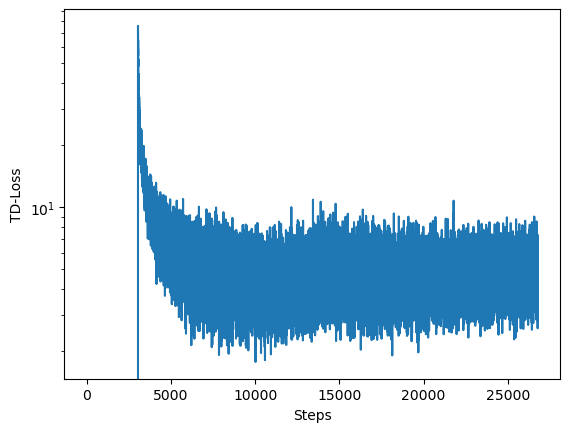

<Figure size 640x480 with 1 Axes>


In [25]:
fig, ax = plt.subplots()
ax.semilogy(all_losses)
ax.set_xlabel("Steps")
ax.set_ylabel("TD-Loss")
fig

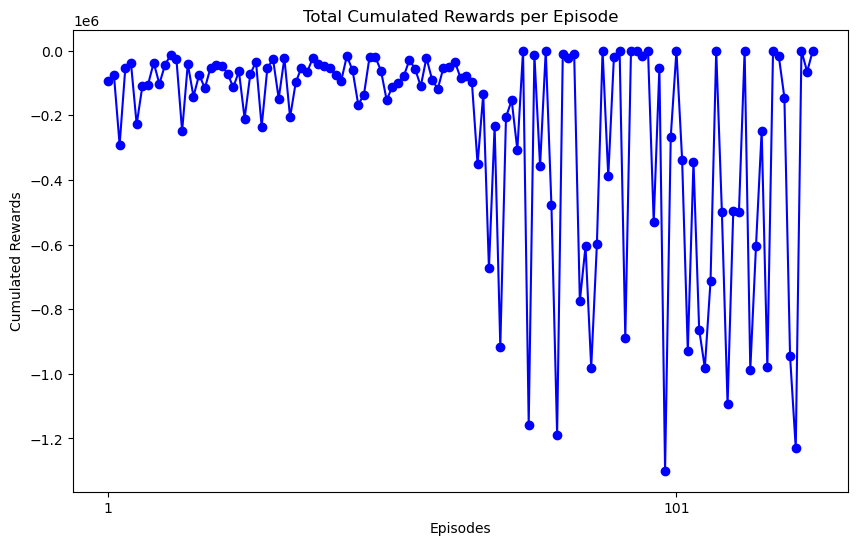

<Figure size 1000x600 with 1 Axes>


In [32]:
simulate.plot_cumulated_rewards(all_rewards)

## 2. Evaluation

In [ ]:
eval_config_paths = [f"./eval_configs/config_{i}.json" for i in range(1, 11)]

In [ ]:
all_results = simulate.evaluate(eval_config_paths, trained_agent)

In [ ]:
display(all_results)

In [ ]:
# Calculate averages for each configuration
averages = all_results.groupby('config_path').mean().reset_index().drop(columns=['episode'])
averages = averages.rename(columns={
    'steps': 'avg_steps',
    'reward': 'avg_reward',
    'evacuated': 'avg_evacuated',
    'deactivated': 'avg_deactivated'})

display(averages)
averages.to_csv('averages.csv', index=False)